links:
 - http://cs231n.github.io/neural-networks-case-study/
 - https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
 - https://deepnotes.io/softmax-crossentropy

In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.misc.pilutil import imread, imresize
from tqdm import tqdm
%matplotlib inline

In [217]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return x * (1 - x)

def softmax(x):
    exp = np.exp(x - np.max(x, axis=0))
    return exp / np.sum(exp, axis=0)

def softmax_grad(x):
    return np.diagflat(x) - np.dot(x, x.T)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return np.int64(x > 0)

def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1 - (np.tanh(x) ** 2)

In [218]:
def calc_accuracy(my, actual):
    sz = len(actual[0])
    return (sz - len(np.nonzero(np.argmax(actual, axis = 0) - np.argmax(my, axis = 0))[0])) / sz

def calc_f1_score(my, actual):
    score_per_class = []
    actual = actual.T
    my = my.T
    for i in range(10):
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        for j in range(len(my)):
            if (np.argmax(actual[j], axis = 0) == i):
                if (np.argmax(my[j], axis = 0) == i):
                    tp += 1
                else:
                    fn += 1
            else:
                if (np.argmax(my[j], axis = 0) == i):
                    fp += 1
                else:
                    tn += 1

        if tp == 0:
            score_per_class.append(0)
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            score_per_class.append(2 * (precision * recall) / (precision + recall))
    return np.average(score_per_class)

def convert_to_multiclass(Y, classes):
    temp = Y.flatten()
    b = np.zeros((len(temp), classes))
    b[np.arange(len(temp)), Y] = 1
    return b

In [219]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [220]:
train_X = train.iloc[:,1:]
train_Y = train.iloc[:,0]
train_X = train_X / 255.
train_Y = convert_to_multiclass(train_Y.as_matrix(), 10)

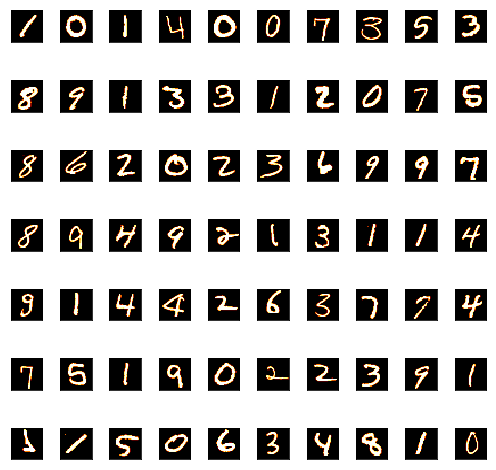

In [221]:
# plot some of the numbers
plt.figure(figsize=(7,7))
for digit_num in range(0,70):
    plt.subplot(7,10,digit_num+1)
    grid_data = train_X.iloc[digit_num].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [222]:
class Layer:
    def __init__(self, prev_n, n, optimizer):
        self.prev_n = prev_n
        self.n = n
        self.optimizer = optimizer
        
    def input_size(self):
        return self.prev_n
    
    def output_size(self):
        return self.n
        
    def initialize(self):
        self.W = np.random.randn(self.n, self.prev_n) / 10.
        self.b = np.zeros((self.n, 1))
        
    def forward_propagation(self):
        pass
        
    def backward_propagation(self):
        pass
    
    def update(self):
        self.W = self.optimizer.get_updated(self.W, self.dW)
        self.b = self.optimizer.get_updated(self.b, self.db)

In [223]:
class HiddenReluLayer(Layer):
    def __init__(self, prev_n, n, optimizer, l2_lambda = 0.1):
        Layer.__init__(self, prev_n, n, optimizer)
        self.l2_lambda = l2_lambda
    
    def forward_propagation(self, prev_A):
        self.prev_A = prev_A
        self.Z = np.dot(self.W, prev_A) + self.b # linear
        self.A = relu(self.Z) # apply relu activation
    
    def backward_propagation(self, m, W_next, dZ_next):
        self.dZ = np.multiply(np.dot(W_next.T, dZ_next), relu_grad(self.A))
        
        self.dW = 1./m * np.dot(self.dZ, self.prev_A.T) + (self.l2_lambda / m) * self.W
        self.db = 1./m * np.sum(self.dZ, axis=1, keepdims=True)

In [224]:
class HiddenSigmoidLayer(Layer):
    def __init__(self, prev_n, n, optimizer, l2_lambda = 0.1):
        Layer.__init__(self, prev_n, n, optimizer)
        self.l2_lambda = l2_lambda
    
    def forward_propagation(self, prev_A):
        self.prev_A = prev_A
        self.Z = np.dot(self.W, prev_A) + self.b # linear
        self.A = sigmoid(self.Z) # apply relu activation
    
    def backward_propagation(self, m, W_next, dZ_next):
        self.dZ = np.multiply(np.dot(W_next.T, dZ_next), sigmoid_grad(self.A))
        
        self.dW = 1./m * np.dot(self.dZ, self.prev_A.T) + (self.l2_lambda / m) * self.W
        self.db = 1./m * np.sum(self.dZ, axis=1, keepdims=True)

In [225]:
class HiddenTanhLayer(Layer):
    def __init__(self, prev_n, n, optimizer, l2_lambda = 0.1):
        Layer.__init__(self, prev_n, n, optimizer)
        self.l2_lambda = l2_lambda
    
    def forward_propagation(self, prev_A):
        self.prev_A = prev_A
        self.Z = np.dot(self.W, prev_A) + self.b # linear
        self.A = tanh(self.Z) # apply relu activation
    
    def backward_propagation(self, m, W_next, dZ_next):
        self.dZ = np.multiply(np.dot(W_next.T, dZ_next), tanh_grad(self.A))
        
        self.dW = 1./m * np.dot(self.dZ, self.prev_A.T) + (self.l2_lambda / m) * self.W
        self.db = 1./m * np.sum(self.dZ, axis=1, keepdims=True)

In [226]:
class OuterSoftmaxLayer(Layer):
    def __init__(self, prev_n, n, optimizer, l2_lambda = 0.1):
        Layer.__init__(self, prev_n, n, optimizer)
        self.l2_lambda = l2_lambda
    
    def forward_propagation(self, prev_A):
        self.prev_A = prev_A
        self.Z = np.dot(self.W, prev_A) + self.b # linear
        self.A = softmax(self.Z) # apply softmax activation
    
    def backward_propagation(self, m, true_label):
        #derivative of the softmax with cross entropy loss function: https://deepnotes.io/softmax-crossentropy
        self.dZ = self.A - true_label.T 
        
        self.dW = 1./m * np.dot(self.dZ, self.prev_A.T) + (self.l2_lambda / m) * self.W
        self.db = 1./m * np.sum(self.dZ, axis=1, keepdims = True)

In [227]:
# Different optimization algorithms
class GradientDescentOptimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    # f - function, g - gradient
    def get_updated(self, f, g):
        return f - self.learning_rate * g

In [239]:
class SimpleBatcher:
    def __init__(self, batch_size=100):
        self.batch_size = batch_size
        self.it = 0
        
    def fit(self, X, Y):
        self.batches = np.floor_divide(X.shape[0], self.batch_size)
        
        self.X = []
        self.Y = []
        for it in range(0, self.batches):
            self.X.append(X[it*self.batch_size:(it+1)*self.batch_size,:])
            self.Y.append(Y[it*self.batch_size:(it+1)*self.batch_size,:])
        
    def next(self):
        self.it = np.random.randint(self.batches)
        
    def get(self):
        return self.X[self.it], self.Y[self.it]

In [240]:
class LayeredNetwork:
    def __init__(self, input_size, output_size, optimizer, l2_lambda=0.1):
        self.l2_lambda = l2_lambda
        self.optimizer = optimizer
        
        self.layers = [
            HiddenTanhLayer(input_size, 27, optimizer, l2_lambda),
            HiddenTanhLayer(27, 27, optimizer, l2_lambda),
            OuterSoftmaxLayer(27, output_size, optimizer, l2_lambda)
        ]
        
        for layer in self.layers:
            layer.initialize()
    
    def set_datasets(self, train_X, train_Y, batcher=SimpleBatcher(batch_size=1)):
        self.train_X = train_X
        self.train_Y = train_Y
        self.batcher = batcher
        self.batcher.fit(train_X, train_Y)
        
    def set_optimizer(optimizer):
        self.optimizer = optimizer
    
    def compute_cost(self, out, actual):
        # cross entropy loss function
        cost = np.multiply(actual, out)
        # add some regularization
        cost = -np.sum(cost)
        
        l2_regularization = 0
        for i in range(0, len(self.layers)):
            l2_regularization += np.sum(np.square(self.layers.W))
        
        cost += self.l2_lambda * l2_regularization
        return cost    
        
    def forward_propagation(self, print_cost=False):
        self.batcher.next()
        X, Y = self.batcher.get()
        
        A = X.T
        for l in range(0, len(self.layers)):
            self.layers[l].forward_propagation(A)
            A = self.layers[l].A

        if print_cost:
            print(self.compute_cost(np.clip(A.T, 1e-30, None), Y))
        
    def backward_propagation(self):
        X, Y = self.batcher.get()
        m = X.shape[0]
        
        for l in range(len(self.layers) - 1, -1, -1):
            if l == len(self.layers) - 1:
                self.layers[l].backward_propagation(m, Y)
            else:
                W_next = self.layers[l + 1].W
                dZ_next = self.layers[l + 1].dZ
                
                self.layers[l].backward_propagation(m, W_next, dZ_next)

    def update(self):
        for layer in self.layers:
            layer.update()
            
    def predict(self, test):
        A = test.T.astype(np.float64)
        
        for l in range(0, len(self.layers)):
            self.layers[l].forward_propagation(A)
            A = self.layers[l].A
                
        return A

In [241]:
network = LayeredNetwork(train_X.shape[1], 10, optimizer=GradientDescentOptimizer(learning_rate=0.01))

In [242]:
def train(network, train_X, train_Y, iters, print_every, plot_every, batch_size=64, learning_rate=0.1):
    f1_score=[]
    network.set_datasets(train_X, train_Y, batcher=SimpleBatcher(batch_size=batch_size))
    network.set_optimizer = GradientDescentOptimizer(learning_rate=learning_rate)
    
    for i in range(iters + 1):
        if i % print_every == 0:
            f1_sc = calc_f1_score(network.predict(train_X), train_Y.T) 
            print(i, f1_sc)
            
        if i % plot_every == 0:
            accuracy = calc_accuracy(network.predict(train_X), train_Y.T)
            f1_score.append(f1_sc)
            
        network.forward_propagation()
        network.backward_propagation()
        network.update()
    return f1_score

In [243]:
f1_scores = train(network, train_X.as_matrix(), train_Y, 20000, 5000, 1000, learning_rate=0.01)

0 0.0521912798958
5000 0.891804449237
10000 0.918916815601
15000 0.929933431501


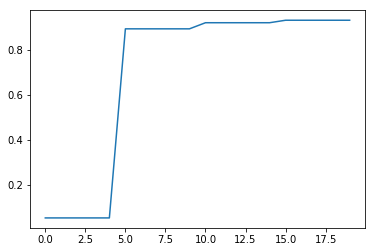

In [245]:
plt.plot(f1_scores)
plt.show()

In [246]:
np.argmax(network.predict(train_X), axis=0)[:10]

array([1, 0, 1, 6, 0, 0, 7, 3, 5, 3])

In [247]:
print(calc_accuracy(network.predict(train_X), train_Y.T))

0.9385952380952381


In [262]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 255. - (0.2989 * r + 0.5870 * g + 0.1140 * b)
    return gray

def get_matrix(file_image):
    init_image = np.array(imread(file_image, flatten=False))
    init_image = imresize(init_image, size=(24,24))
    init_image = rgb2gray(init_image) 
    # centering
    img = np.zeros((28, 28))
    for i in range(2, 25):
        for j in range(2, 25):
            img[i][j] = init_image[i - 2][j - 2]
    return img

# image is array 28x28
def draw(image):
    plt.imshow(image, interpolation = "none", cmap="gray")

In [263]:
def pretty_predict(file):
    image = get_matrix(file)
    draw(image)
    print("Network predicted that this is {}".format(np.argmax(network.predict(image.reshape(1, 28 * 28)))))

In [264]:
def train_on(file, label):
    tX = get_matrix(file).reshape(1, 28 * 28)
    tY = np.zeros((1, 10))
    tY[0][label] = 1.
    
    train(network, tX, tY, 10, 1, 1, batch_size=1, learning_rate=0.1)

Network predicted that this is 9


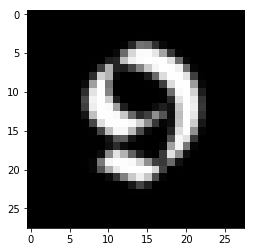

In [281]:
pretty_predict("test_pics/pic9.png")

In [275]:
train_on("test_pics/pic9.png", 9)

0 0.0
1 0.1
2 0.1
3 0.1
4 0.1
5 0.1
6 0.1
7 0.1
8 0.1
9 0.1


Network predicted that this is 9


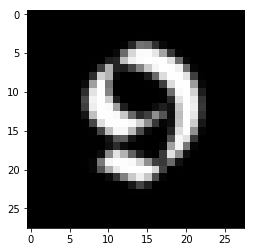

In [276]:
pretty_predict("test_pics/pic9.png")